# Sentiment Based Product Recommendation System

### Problem Statement

You are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

 

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

 

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

 

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

* Data sourcing and sentiment analysis
* Building a recommendation system
* Improving the recommendations using the sentiment analysis model
* Deploying the end-to-end project with a user interface

### Process going to be followed,

>**Step 1:** Data sourcing<br>
**Step 2:** EDA & Data Cleaning<br>
**Step 3:** Text Preprocessing<br>
**Step 4:** Feature Extraction<br>
**Step 5:** Sentiment Modelling<br>
**Step 6:** Recommendation System<br>
**Step 7:** Final Product Recommendations - Using Recommendation system and Sentiment model<br>

#### Step 1 - Data Sourcing
Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import time
import pickle
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity


Loading the dataset

In [3]:
# Getting the dataset
df_reviews = pd.read_csv("dataset/sample30.csv")
df_reviews.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   
3  I read through the reviews on here before look...  Disappointed   
4  My husband bought this gel for us. The gel cau...    Irritation   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive  
3              NaN                  NaN          rebecca       Negative  
4              NaN                  NaN        walker557       Negative

In [4]:
df_reviews.shape

(30000, 15)

We have 30,000 reviews with 15 fields

In [5]:
df_reviews.describe()

reviews_rating
count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000

The only numerical column is Rating. We have very good rating overall, almost 75% of ratings are >= 4. We will check in detail shortly.

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

We can see we have some null values in few columns. We don't have any null in **rating** but we do have only one null value in one of our main variable **user_sentiment**.

#### Step 2: EDA & Data Cleaning

In [7]:
# Let's recheck the null values count again
df_reviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [8]:
# Let's drop the row which has null value in user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [9]:
# Let's check the shape again
df_reviews.shape

(29999, 15)

In [10]:
df_reviews.brand.nunique()

214

In [11]:
df_reviews.reviews_username.nunique()

24914

In [12]:
df_reviews.name.nunique()

271

So we have 30,000 reviews from 25k users (approx) for 214 brands and 271 different products.

In [13]:
# let's check how the reviews_rating are spread over 1 to 5
df_reviews.reviews_rating.value_counts()

5    20830
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

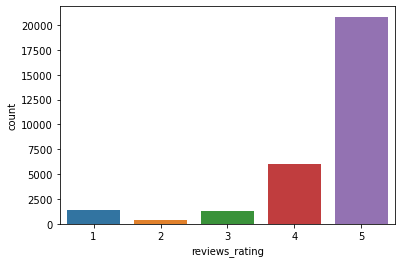

In [14]:
# let's visualize it
sns.countplot(data=df_reviews,x='reviews_rating')

As we already said, most of the Ratings are 4 or 5 in the dataset.

In [15]:
# let's check how the user_sentiment spread over
df_reviews.user_sentiment.value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [16]:
# Let's try to map positive to 1 and negative to 0
df_reviews.user_sentiment = df_reviews.user_sentiment.map(lambda x: 1 if x == 'Positive' else 0)

In [17]:
# Let's check the counts again
df_reviews.user_sentiment.value_counts()

1    26632
0     3367
Name: user_sentiment, dtype: int64

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

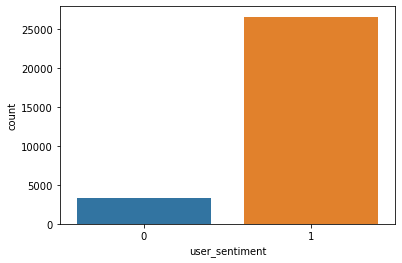

In [18]:
# let's visualize it
sns.countplot(data=df_reviews,x='user_sentiment')

We can see that positive reviews are very huge when compared to negative reviews count i.e. class imbalance. We will handle it before modeling

In [19]:
# let's see some of the positive reviews
df_reviews[df_reviews.user_sentiment == 1].head(20)

id            brand  \
0   AV13O1A8GV-KLJ3akUyj  Universal Music   
1   AV14LG0R-jtxr-f38QfS         Lundberg   
2   AV14LG0R-jtxr-f38QfS         Lundberg   
9   AV16khLE-jtxr-f38VFn              K-Y   
11  AV16khLE-jtxr-f38VFn              K-Y   
14  AV16khLE-jtxr-f38VFn              K-Y   
18  AV16khLE-jtxr-f38VFn              K-Y   
20  AV16khLE-jtxr-f38VFn              K-Y   
21  AV16khLE-jtxr-f38VFn              K-Y   
22  AV16khLE-jtxr-f38VFn              K-Y   
23  AV16khLE-jtxr-f38VFn              K-Y   
24  AV16khLE-jtxr-f38VFn              K-Y   
25  AV16khLE-jtxr-f38VFn              K-Y   
26  AV16khLE-jtxr-f38VFn              K-Y   
27  AV16khLE-jtxr-f38VFn              K-Y   
28  AV16khLE-jtxr-f38VFn              K-Y   
29  AV16khLE-jtxr-f38VFn              K-Y   
30  AV1d76w7vKc47QAVhCqn     J.R. Watkins   
31  AV1d76w7vKc47QAVhCqn     J.R. Watkins   
32  AV1d76w7vKc47QAVhCqn     J.R. Watkins   

                                           categories  \
0   Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1   Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2   Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
9   Personal Care,Medicine Cabinet,Lubricant/Sperm...   
11  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
14  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
18  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
20  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
21  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
22  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
23  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
24  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
25  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
26  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
27  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
28  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
29  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
30  Personal Care,Skin Care,Hand Cream,Beauty,Body...   
31  Personal Care,Skin Care,Hand Cream,Beauty,Body...   
32  Personal Care,Skin Care,Hand Cream,Beauty,Body...   

                          manufacturer  \
0   Universal Music Group / Cash Money   
1                             Lundberg   
2                             Lundberg   
9                                  K-Y   
11                                 K-Y   
14                                 K-Y   
18                                 K-Y   
20                                 K-Y   
21                                 K-Y   
22                                 K-Y   
23                                 K-Y   
24                                 K-Y   
25                                 K-Y   
26                                 K-Y   
27                                 K-Y   
28                                 K-Y   
29                                 K-Y   
30                        J.R. Watkins   
31                        J.R. Watkins   
32                        J.R. Watkins   

                                          name              reviews_date  \
0    Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1   Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2   Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
9             K-Y Love Sensuality Pleasure Gel  2016-03-21T00:00:00.000Z   
11            K-Y Love Sensuality Pleasure Gel  2016-04-05T00:00:00.000Z   
14            K-Y Love Sensuality Pleasure Gel  2016-01-09T00:00:00.000Z   
18            K-Y Love Sensuality Pleasure Gel  2016-01-01T00:00:00.000Z   
20            K-Y Love Sensuality Pleasure Gel  2016-05-12T00:00:00.000Z   
21            K-Y Love Sensuality Pleasure Gel  2015-11-04T00:00:00.000Z   
22            K-Y Love Sensuality Pleasure Gel  2016-01-07T00:00:00.000Z   
23            K-Y Love Sensuality Pleasure Gel  2017-08-15T00:00:00.000Z   
24            K-Y Love Sensuality Pleasure Gel  2016-11-26T00:00:00.000Z   
25     

There is a small error here, the rating is given as 1 which is a least rating but came in positive reviews, which is contradicting.

In [20]:
# let's check the vice versa. Some of the negative reviews
df_reviews[df_reviews.user_sentiment == 0].sample(20)

id              brand  \
9253   AVpf3VOfilAPnD_xjpun             Clorox   
22889  AVpfPaoqLJeJML435Xk9  Warner Home Video   
12788  AVpf3VOfilAPnD_xjpun             Clorox   
21376  AVpfm8yiLJeJML43AYyu             Nexxus   
21638  AVpfm8yiLJeJML43AYyu             Nexxus   
7342   AVpf3VOfilAPnD_xjpun             Clorox   
10446  AVpf3VOfilAPnD_xjpun             Clorox   
27814  AVpfRTh1ilAPnD_xYic2             Disney   
1023   AV1YGDqsGV-KLJ3adc-O             Windex   
21499  AVpfm8yiLJeJML43AYyu             Nexxus   
11075  AVpf3VOfilAPnD_xjpun             Clorox   
23493  AVpfPaoqLJeJML435Xk9  Warner Home Video   
26237  AVpfpM2yilAPnD_xfmDG               Ragu   
11126  AVpf3VOfilAPnD_xjpun             Clorox   
20073  AVpfJP1C1cnluZ0-e3Xy             Clorox   
28368  AVpfrTyiLJeJML43BrSI               UMGD   
12632  AVpf3VOfilAPnD_xjpun             Clorox   
22205  AVpfOfIqLJeJML435D06         Solo Foods   
4533   AVpf0eb2LJeJML43EVSt      Sony Pictures   
8744   AVpf3VOfilAPnD_xjpun             Clorox   

                                              categories  \
9253   Household Essentials,Cleaning Supplies,Kitchen...   
22889  Movies, Music & Books,Movies,Action & Adventur...   
12788  Household Essentials,Cleaning Supplies,Kitchen...   
21376  Personal Care,Hair Care,Styling Gel/Lotion,Bea...   
21638  Personal Care,Hair Care,Styling Gel/Lotion,Bea...   
7342   Household Essentials,Cleaning Supplies,Kitchen...   
10446  Household Essentials,Cleaning Supplies,Kitchen...   
27814  Movies, Music & Books,Movies,Kids' & Family,Wa...   
1023   Household Essentials,Cleaning Supplies,Glass C...   
21499  Personal Care,Hair Care,Styling Gel/Lotion,Bea...   
11075  Household Essentials,Cleaning Supplies,Kitchen...   
23493  Movies, Music & Books,Movies,Action & Adventur...   
26237  Food,Packaged Foods,Condiments, Dips, & Salad ...   
11126  Household Essentials,Cleaning Supplies,Kitchen...   
20073  Household Chemicals,Household Cleaners,Bath & ...   
28368  Movies, Music & Books,Music,Kids' Music,Music ...   
12632  Household Essentials,Cleaning Supplies,Kitchen...   
22205  Food,Packaged Foods,Baking,Pie Fillings,Home &...   
4533   Movies, Music & Books,Ways To Shop Entertainme...   
8744   Household Essentials,Cleaning Supplies,Kitchen...   

                 manufacturer  \
9253                   Clorox   
22889                    Test   
12788                  Clorox   
21376  Nexxus Beauty Products   
21638  Nexxus Beauty Products   
7342                   Clorox   
10446                  Clorox   
27814             Walt Disney   
1023                   Windex   
21499  Nexxus Beauty Products   
11075                  Clorox   
23493                    Test   
26237                Unilever   
11126                  Clorox   
20073          AmazonUs/CLOO7   
28368     Walt Disney Records   
12632                  Clorox   
22205                    Solo   
4533                SONY CORP   
8744                   Clorox   

                                                    name  \
9253   Clorox Disinfecting Wipes Value Pack Scented 1...   
22889  Godzilla 3d Includes Digital Copy Ultraviolet ...   
12788  Clorox Disinfecting Wipes Value Pack Scented 1...   
21376          Nexxus Exxtra Gel Style Creation Sculptor   
21638          Nexxus Exxtra Gel Style Creation Sculptor   
7342   Clorox Disinfecting Wipes Value Pack Scented 1...   
10446  Clorox Disinfecting Wipes Value Pack Scented 1...   
27814  Planes: Fire Rescue (2 Discs) (includes Digita...   
1023   Windex Original Glass Cleaner Refill 67.6oz (2...   
21499          Nexxus Exxtra Gel Style Creation Sculptor   
11075  Clorox Disinfecting Wipes Value Pack Scented 1...   
23493  Godzilla 3d Includes Digital Copy Ultraviolet ...   
26237                       Ragu Traditional Pasta Sauce   
11126  Clorox Disinfecting Wipes Value Pack Scented 1...   
20073               Clorox Disinfecting Bathroom Cleaner   
28368              Various Artists - Choo Choo Soul (cd)   

Here also it is contradicting, we have some reviews with 5 stars, came here in negative reviews. let's try to get the exact count.

In [21]:
# let's get the data spread across reviews rating and user sentiment using crosstab
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating     1    2     3     4      5    All
user_sentiment                                     
0                597  140   220   550   1860   3367
1                787  280  1125  5470  18970  26632
All             1384  420  1345  6020  20830  29999

We can clearly see that for negative reviews we have higher ratings and vice versa.<br> So, let's try to change the user_sentiment accordingly since it will help in modelling or to get the correct results.<br> Let's fix 1(positive) for ratings >= 4 which is 0(negative) now,<br>And 0(negative) for ratings < 4 which is 1(positive) now.

In [22]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [23]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [24]:
# Let's check the count again
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating     1    2     3     4      5    All
user_sentiment                                     
0               1384  420  1345     0      0   3149
1                  0    0     0  6020  20830  26850
All             1384  420  1345  6020  20830  29999

<AxesSubplot:xlabel='reviews_rating'>

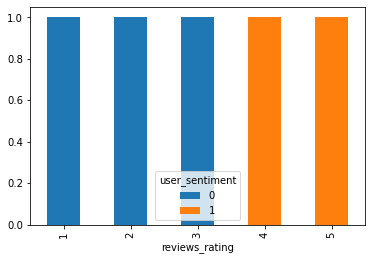

In [25]:
# Let's plot it
df_reviews.groupby('reviews_rating').user_sentiment.value_counts(normalize=True).unstack().plot(kind='bar',stacked=True)

Looks good now. Rating 1,2 and 3 has negative value(0) & Ratings 4 and 5 has positive value(1).

Out of given 15 fields, we need only id, reviews_rating, user_sentiment, reviews_text, reviews_title, username and name fields. Let's check these fields.

In [26]:
df_reviews[['id', 'reviews_rating', 'user_sentiment', 'reviews_text', 'reviews_title', 'reviews_username','name']].isnull().sum()

id                    0
reviews_rating        0
user_sentiment        0
reviews_text          0
reviews_title       190
reviews_username     63
name                  0
dtype: int64

Since we are going to merge the review_title with the review_text and review_text has zero null values, we dont need to handle with it now. <br>
Reviews_username has 63 null values, which need to be dropped.

In [27]:
# Removing reviews don't have reviews_username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [28]:
df_reviews.shape

(29936, 15)

In [29]:
# Let's merge the review text and review title for better analysis
# Firstly fill review title null values with blank value.
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')

# Now let's merge them
df_reviews["full_review_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [30]:
# Let's take all the columns needed
df_reviews[['id','name','reviews_username','reviews_text', 'reviews_title', 'full_review_text', 'reviews_rating', 'user_sentiment']].isnull().sum()

id                  0
name                0
reviews_username    0
reviews_text        0
reviews_title       0
full_review_text    0
reviews_rating      0
user_sentiment      0
dtype: int64

In [31]:
pd.set_option('display.max_colwidth', 200)

# Let's create a separate df with these fields
main_df = df_reviews[['id','name','reviews_username','reviews_text', 'reviews_title', 'full_review_text', 'reviews_rating', 'user_sentiment']]

In [32]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29936 non-null  object
 1   name              29936 non-null  object
 2   reviews_username  29936 non-null  object
 3   reviews_text      29936 non-null  object
 4   reviews_title     29936 non-null  object
 5   full_review_text  29936 non-null  object
 6   reviews_rating    29936 non-null  int64 
 7   user_sentiment    29936 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.1+ MB


<AxesSubplot:>

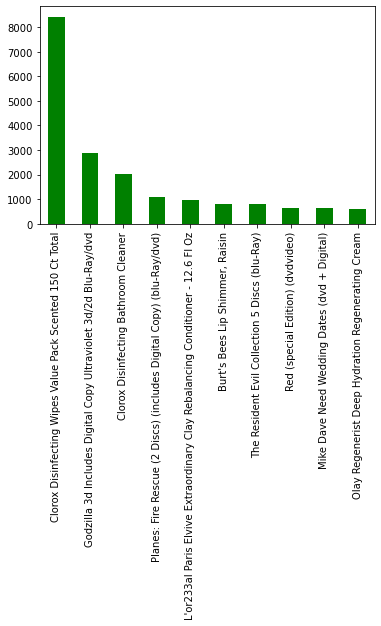

In [33]:
# Let's get the top 10 best products
main_df[main_df['reviews_rating'] >= 4].name.value_counts()[:10].plot(kind='bar',color='Green')

<AxesSubplot:>

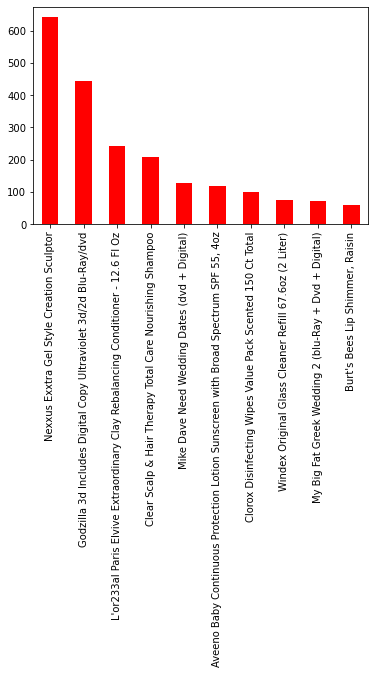

In [34]:
# Let's get the top 10 worst products
main_df[main_df['reviews_rating'] < 4].name.value_counts()[:10].plot(kind='bar',color='Red')

Now lets try to get product's positive responses count as well as negative responses count.

In [35]:
# Let's try to get the product_wise_sentiment count
product_sentiment = main_df.groupby('name').user_sentiment.value_counts()

# convert it into dataframe
product_sentiment = pd.DataFrame(product_sentiment)

# We have percentile, let's get the percentile now
product_sentiment['Percentage'] = main_df.groupby('name').user_sentiment.value_counts(normalize=True)

#Renaming the column and converting the multi level index into columns
product_sentiment.rename(columns = {'user_sentiment':'review_count'}, inplace = True)
product_sentiment = product_sentiment.reset_index()

#Sorting according to percentile and count to get the best products which has more and 100% unique response
product_sentiment.sort_values(by=['Percentage','review_count'],inplace=True,ascending=False)
product_sentiment

name  \
351                                               Sopranos:Season 6 Part 1 (blu-Ray)   
24                                        Australian Gold Exotic Blend Lotion, SPF 4   
72                                                     Cars Toon: Mater's Tall Tales   
181                                        Jolly Time Select Premium Yellow Pop Corn   
300                                Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black   
..                                                                               ...   
198      Kraus FVS-1007 Single Hole Vessel Bathroom Faucet from the Ramus Collection   
29   Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter   
98                                              Clorox Disinfecting Bathroom Cleaner   
100                        Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
59                                      Bounce Dryer Sheets, Fresh Linen, 160 sheets   

     user_sentiment  review_count  Percentage  
351               1            68    1.000000  
24                1            34    1.000000  
72                1            34    1.000000  
181               1            27    1.000000  
300               1            27    1.000000  
..              ...           ...         ...  
198               0             1    0.027027  
29                0             6    0.019169  
98                0            30    0.014713  
100               0            98    0.011496  
59                0             1    0.011494  

[429 rows x 4 columns]

For example, Sopranos:Season 6 Part 1 (blu-Ray) have 68 positive responce and zero negative responce.

#### Step 3: Text Preprocessing

We are going to clean the reviews by removing spaces, numbers, punctuations and bringing it to lower case then lemmatizing (base form) the text.

In [36]:
# Download if necessary, its better to check once
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [37]:
main_df

id  \
0      AV13O1A8GV-KLJ3akUyj   
1      AV14LG0R-jtxr-f38QfS   
2      AV14LG0R-jtxr-f38QfS   
3      AV16khLE-jtxr-f38VFn   
4      AV16khLE-jtxr-f38VFn   
...                     ...   
29995  AVpfW8y_LJeJML437ySW   
29996  AVpfW8y_LJeJML437ySW   
29997  AVpfW8y_LJeJML437ySW   
29998  AVpfW8y_LJeJML437ySW   
29999  AVpfW8y_LJeJML437ySW   

                                                                                 name  \
0                                           Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1                                          Lundberg Organic Cinnamon Toast Rice Cakes   
2                                          Lundberg Organic Cinnamon Toast Rice Cakes   
3                                                    K-Y Love Sensuality Pleasure Gel   
4                                                    K-Y Love Sensuality Pleasure Gel   
...                                                                               ...   
29995  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29996  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29997  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29998  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29999  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   

      reviews_username  \
0               joshua   
1            dorothy w   
2            dorothy w   
3              rebecca   
4            walker557   
...                ...   
29995       laurasnchz   
29996    scarlepadilla   
29997       liviasuexo   
29998         ktreed95   
29999        kcoopxoxo   

                                                                                                                                                                                                  reviews_text  \
0      i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just c...   
1                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                 Good flavor.   
3      I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, n...   
4                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   
...                                                                                                                                                                                                        ...   
29995  I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! This review was collect...   
29996                                                                                  I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great   
29997  First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my ...   
29998  I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not ma

In [38]:
# Let's get the cleaned review text
def preprocess(document):
    # tokenize into words
    words = word_tokenize(document)
    words = list(map(str.lower,words))
    document = ' '.join(s for s in words if not any(c.isdigit() for c in s))
    res = re.sub(r'[^\w\s]', '', document)
    return res

In [39]:
# Let's clean the data
main_df["Cleaned_review_text"] = main_df.full_review_text.apply(lambda x: preprocess(x))
main_df

id  \
0      AV13O1A8GV-KLJ3akUyj   
1      AV14LG0R-jtxr-f38QfS   
2      AV14LG0R-jtxr-f38QfS   
3      AV16khLE-jtxr-f38VFn   
4      AV16khLE-jtxr-f38VFn   
...                     ...   
29995  AVpfW8y_LJeJML437ySW   
29996  AVpfW8y_LJeJML437ySW   
29997  AVpfW8y_LJeJML437ySW   
29998  AVpfW8y_LJeJML437ySW   
29999  AVpfW8y_LJeJML437ySW   

                                                                                 name  \
0                                           Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1                                          Lundberg Organic Cinnamon Toast Rice Cakes   
2                                          Lundberg Organic Cinnamon Toast Rice Cakes   
3                                                    K-Y Love Sensuality Pleasure Gel   
4                                                    K-Y Love Sensuality Pleasure Gel   
...                                                                               ...   
29995  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29996  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29997  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29998  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29999  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   

      reviews_username  \
0               joshua   
1            dorothy w   
2            dorothy w   
3              rebecca   
4            walker557   
...                ...   
29995       laurasnchz   
29996    scarlepadilla   
29997       liviasuexo   
29998         ktreed95   
29999        kcoopxoxo   

                                                                                                                                                                                                  reviews_text  \
0      i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just c...   
1                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                 Good flavor.   
3      I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, n...   
4                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   
...                                                                                                                                                                                                        ...   
29995  I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! This review was collect...   
29996                                                                                  I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great   
29997  First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my ...   
29998  I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not ma

In [40]:
# Creating a function for removing stop words
stop_words = set(stopwords.words('english'))

def remove_stop_words(doc):
    words = [word for word in doc.split() if word.isalpha() and word not in stop_words]
    return " ".join (words)
    

In [41]:
# Let's create a lemmatizer function - to get all the words to its base form(lemma)
wordnet_lemmatizer = WordNetLemmatizer()

# Let's create a lemmatization helper func to get the tags accordingly 
def get_words_tag(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Creating lemmatizer func after removing stop words and matching the tag with the helper func
def lemmatize (document):
      word_pos_tags = nltk.pos_tag(word_tokenize(remove_stop_words(document)))
      words =[wordnet_lemmatizer.lemmatize(tag[0], get_words_tag(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
      return " ".join(words)

In [42]:
# Let's lemmatize the text
main_df["lemmatized_review_text"] = main_df["Cleaned_review_text"].map(lemmatize)
main_df

id  \
0      AV13O1A8GV-KLJ3akUyj   
1      AV14LG0R-jtxr-f38QfS   
2      AV14LG0R-jtxr-f38QfS   
3      AV16khLE-jtxr-f38VFn   
4      AV16khLE-jtxr-f38VFn   
...                     ...   
29995  AVpfW8y_LJeJML437ySW   
29996  AVpfW8y_LJeJML437ySW   
29997  AVpfW8y_LJeJML437ySW   
29998  AVpfW8y_LJeJML437ySW   
29999  AVpfW8y_LJeJML437ySW   

                                                                                 name  \
0                                           Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1                                          Lundberg Organic Cinnamon Toast Rice Cakes   
2                                          Lundberg Organic Cinnamon Toast Rice Cakes   
3                                                    K-Y Love Sensuality Pleasure Gel   
4                                                    K-Y Love Sensuality Pleasure Gel   
...                                                                               ...   
29995  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29996  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29997  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29998  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29999  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   

      reviews_username  \
0               joshua   
1            dorothy w   
2            dorothy w   
3              rebecca   
4            walker557   
...                ...   
29995       laurasnchz   
29996    scarlepadilla   
29997       liviasuexo   
29998         ktreed95   
29999        kcoopxoxo   

                                                                                                                                                                                                  reviews_text  \
0      i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just c...   
1                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                 Good flavor.   
3      I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, n...   
4                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   
...                                                                                                                                                                                                        ...   
29995  I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! This review was collect...   
29996                                                                                  I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great   
29997  First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my ...   
29998  I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not ma

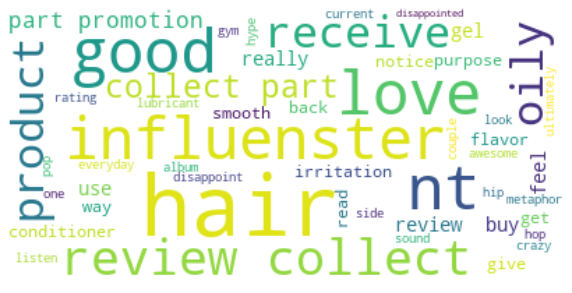

In [43]:
#Using a word cloud finding the top 50 words by frequency among all the reviews after processing the text
wordcloud = WordCloud(max_font_size=60, max_words=50, 
                      background_color="white", random_state=100, 
                      stopwords=stop_words).generate(str(main_df['lemmatized_review_text']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see words like hair, good, influenster, nt, review collect and love are frequently appearing in the reviews.

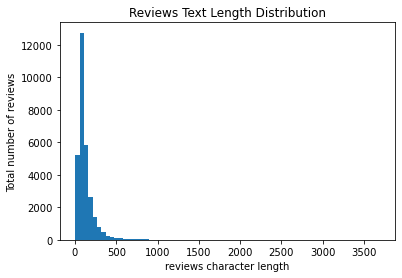

<Figure size 720x432 with 0 Axes>

In [44]:
# Writing the code here to visualise the data according to the 'reviews' character length

character_length=[len(complaint) for complaint in main_df['lemmatized_review_text']]
plt.hist(character_length,bins=70)

plt.xlabel("reviews character length")
plt.ylabel("Total number of reviews")
plt.title("Reviews Text Length Distribution")
plt.figure(figsize=[10,6])
plt.show()

We can see that, most of the reviews have below 500 characters.

In [45]:
# Let's find the top unigrams,bigrams and trigrams by frequency among all the reviews after processing the text.

# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]


In [46]:
# Let's get some unigrams
top_30_unigrams = get_top_ngrams(main_df['lemmatized_review_text'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30_unigrams, columns=['unigram', 'count'])
df_unigram

unigram  count
0       great  15080
1         use  13560
2        love  13028
3     product  12819
4       movie  10942
5      review   9486
6   promotion   8746
7        wipe   8352
8       clean   8339
9     collect   8298
10       good   7330
11     clorox   6022
12         nt   5581
13       like   5204
14       hair   4888
15      smell   4623
16       easy   4322
17       make   4042
18       work   3405
19       best   3025
20     really   2939
21       time   2933
22   godzilla   2779
23        buy   2552
24       look   2541
25       feel   2342
26  disinfect   2325
27       year   2262
28        old   2157
29        new   2133

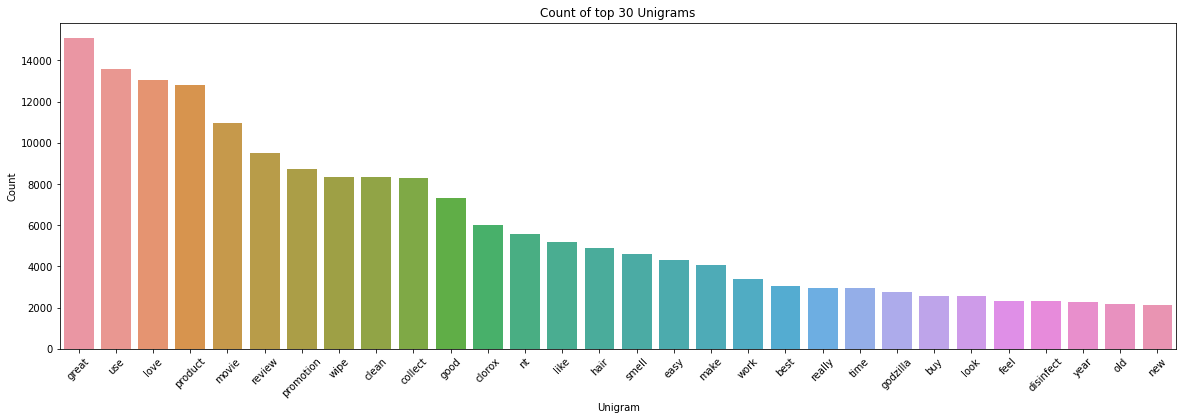

In [47]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [48]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

unigram  count
0      great  15080
1        use  13560
2       love  13028
3    product  12819
4      movie  10942
5     review   9486
6  promotion   8746
7       wipe   8352
8      clean   8339
9    collect   8298

In [49]:
# Let's get some bigrams
top_30_bigrams = get_top_ngrams(main_df['lemmatized_review_text'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30_bigrams, columns=['bigram', 'count'])
df_bigram

bigram  count
0      review collect   8271
1   collect promotion   8271
2         clorox wipe   2848
3       great product   2036
4         great movie   1780
5            easy use   1600
6         love clorox   1234
7        love product   1190
8          use clorox   1101
9          good movie   1034
10        product use    976
11        use product    972
12        movie great    859
13     disinfect wipe    847
14              ca nt    846
15          love love    836
16        smell great    832
17           love use    755
18         work great    720
19       product love    675
20          love wipe    671
21         love movie    670
22   clorox disinfect    610
23     godzilla movie    598
24           use wipe    594
25        lip shimmer    584
26      product great    565
27        new formula    538
28          wipe love    538
29        old formula    524

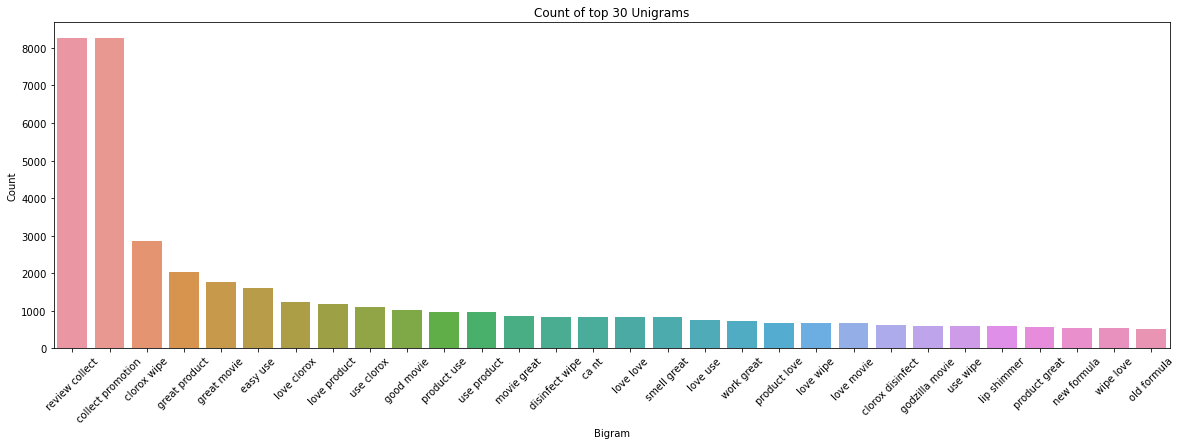

In [50]:
# Plotting top 30 df_bigram
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [51]:
#Print the top 10 words in the df_bigram frequency
df_bigram.head(10)

bigram  count
0     review collect   8271
1  collect promotion   8271
2        clorox wipe   2848
3      great product   2036
4        great movie   1780
5           easy use   1600
6        love clorox   1234
7       love product   1190
8         use clorox   1101
9         good movie   1034

In [52]:
# Let's get some trigrams
top_30_trigrams = get_top_ngrams(main_df['lemmatized_review_text'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30_trigrams, columns=['trigram', 'count'])
df_trigram

trigram  count
0     review collect promotion   8271
1             love clorox wipe    612
2              use clorox wipe    559
3        clorox disinfect wipe    554
4   review collected promotion    470
5         clean review collect    436
6           use review collect    358
7       product review collect    347
8           great product love    296
9            great movie great    272
10            clorox wipe love    254
11      opinion review collect    254
12           movie great movie    250
13             love use clorox    249
14           great product use    247
15               wipe easy use    243
16           bring old formula    240
17              love love love    228
18            product easy use    222
19        receive product free    204
20         wipe review collect    197
21             clorox wipe use    189
22        great review collect    188
23         great product great    180
24        house review collect    177
25           clorox wipe great    174
26         love review collect    171
27         love clorox product    170
28            love product use    169
29            use product year    168

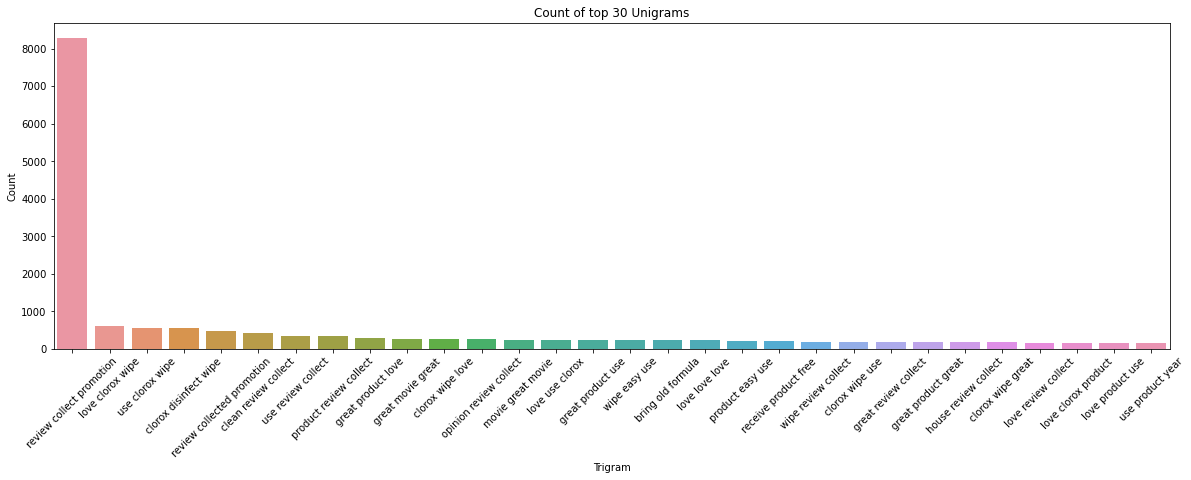

In [53]:
# Plotting top 30 trigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [54]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

trigram  count
0    review collect promotion   8271
1            love clorox wipe    612
2             use clorox wipe    559
3       clorox disinfect wipe    554
4  review collected promotion    470
5        clean review collect    436
6          use review collect    358
7      product review collect    347
8          great product love    296
9           great movie great    272

#### Step 4: Feature Extraction

Converting the raw texts to a matrix of TF-IDF features<br>
For that we only need lemmatized_review_text and user_Sentiment to go ahead.

In [55]:
# Initializing the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english',binary=True)


In [56]:
# creating the Document Term Matrix
X_tfidf = tfidf.fit_transform(main_df['lemmatized_review_text'])
y = main_df['user_sentiment']

In [57]:
# Getting the features
print(tfidf.get_feature_names())

['aaron', 'abandon', 'abd', 'ability', 'able', 'abomination', 'abosolutely', 'abrasive', 'abs', 'absence', 'absobency', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absorbed', 'absorbes', 'absorbs', 'abundance', 'abundant', 'ac', 'academy', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessible', 'accessory', 'accessout', 'accident', 'accidental', 'accidentally', 'accidently', 'accommodate', 'accompany', 'accomplish', 'accord', 'accordingly', 'account', 'accountant', 'accumulate', 'accumulates', 'accurate', 'accurately', 'accustom', 'accutane', 'acdc', 'ache', 'achieve', 'achievement', 'acid', 'acknowledge', 'acne', 'acquire', 'acrylic', 'act', 'acted', 'acting', 'action', 'actioncomedy', 'actionintrigue', 'actionpacked', 'actiony', 'activate', 'active', 'actively', 'activity', 'actor', 'actorsactresses', 'actress', 'actual', 'actually', 'actualy', 'acutally', 'ad', 'adam', 'adapt', 'adaptation', 'adapter', 'adaption', 'add', 'added', 'addict', 'addict

In [58]:
print(len(tfidf.get_feature_names()))

8352


We have our features now. Before going any further, let's check the target variable once.

In [59]:
y.value_counts()

1    26801
0     3135
Name: user_sentiment, dtype: int64

As we already seen, there is a huge class imbalance here. Let's clear it out using SMOTE <br>
Firstly let's split our train and test data


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [61]:
# Treating class imbalance using SMOTE
counter = Counter(y_train)
print('Before',counter)

smote = SMOTE()

# transform the dataset
X_train, y_train = smote.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 18721, 0: 2234})
After Counter({0: 18721, 1: 18721})


#### Step 5: Model Building for sentiment analysis
Firstly let's define some functions which will help in building models and helpful in deployment

In [62]:
class ml_model_creator:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
                
    def training_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
        
    def evaluating_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy : {accuracy*100:.1f}%")
        print(f"Precision : {precision*100:.1f}%")
        print(f"Recall : {recall*100:.1f}%")
        print(f"F1 Score : {f1score*100:.1f}%")
        print(f"Roc-Auc Score :{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def ploting_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Greens", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="Actual Values", xlabel="Predicted Values")
        plt.show()
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.ploting_confusion_matrix(confusion_matrix,[0,1])
           
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*25)
        self.result_metrics = self.evaluating_metrics(y_pred_class)
        print("*"*25)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("*"*25)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("*"*25)
        print("\n")
        
        metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
               

We have created the required functions. Let's start building the models.
### Model 1: Logistic Regression


In [63]:
# Initializing logistic regression model using the class ml_model_creator
%time
logreg = LogisticRegression(random_state=42, solver='liblinear', class_weight="balanced")
logreg_model = ml_model_creator(logreg, X_train, X_test, y_train, y_test)

Wall time: 0 ns


In [64]:
# Training the model using training_model function
%time
y_pred = logreg_model.training_model()

Wall time: 0 ns




*************************
Accuracy : 88.4%
Precision : 97.2%
Recall : 89.7%
F1 Score : 93.3%
Roc-Auc Score :91.1%
*************************


              precision    recall  f1-score   support

           0       0.45      0.77      0.57       901
           1       0.97      0.90      0.93      8080

    accuracy                           0.88      8981
   macro avg       0.71      0.83      0.75      8981
weighted avg       0.92      0.88      0.90      8981

*************************




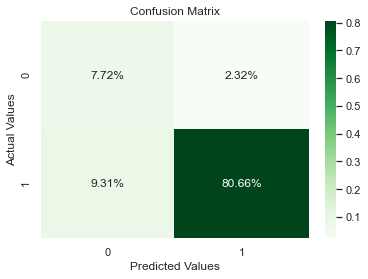

*************************




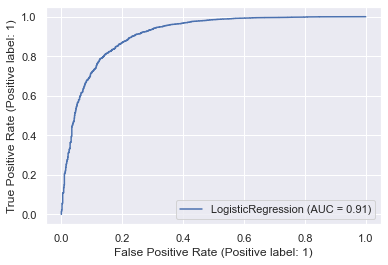

In [65]:
# Evaluvating the model using the evaluate_model function
logreg_metrics = logreg_model.evaluate_model(y_pred)

The overall accuracy, precision and recall was good. Even ROC and Fl score was fine. But if we see class wise separately, class zero was not performing well. So let's try to play with different parameters using gridsearchCV and let's see

In [66]:
%time
# Initializing different param combinations
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring="f1")

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);


Wall time: 0 ns
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [67]:
# Check best parameters
logreg_hpt.best_params_

{'C': 100, 'solver': 'liblinear'}

In [68]:
# Getting the best logreg model
logreg_best = logreg_hpt.best_estimator_
logreg_best

LogisticRegression(C=100, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [69]:
# Initializing the logreg_best model in the class ml_model_creator
logreg_best_model = ml_model_creator(logreg_best, X_train, X_test, y_train, y_test)

Wall time: 0 ns


*************************
Accuracy : 88.4%
Precision : 96.1%
Recall : 90.7%
F1 Score : 93.3%
Roc-Auc Score :86.9%
*************************


              precision    recall  f1-score   support

           0       0.45      0.67      0.54       901
           1       0.96      0.91      0.93      8080

    accuracy                           0.88      8981
   macro avg       0.70      0.79      0.74      8981
weighted avg       0.91      0.88      0.89      8981

*************************




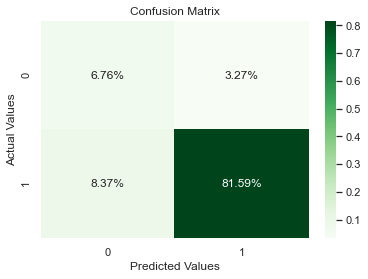

*************************




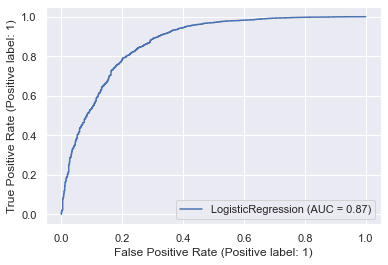

In [70]:
# Training and Predicting the Test Labels
%time
y_pred = logreg_best_model.training_model()
logreg_metrics = logreg_best_model.evaluate_model(y_pred)

Well even after the hyperparameter tuning, there are not much difference. In Class 0 it is still not performing well. So let's try different model.

### Model 2: Naive Bayes

In [71]:
# Initializing naive bayes model using the class ml_model_creator
NB = MultinomialNB(alpha=1.0)
NB_model = ml_model_creator(NB, X_train, X_test, y_train, y_test)

In [72]:
# Training the model using training_model function
%time
y_pred = NB_model.training_model()

Wall time: 0 ns




*************************
Accuracy : 84.4%
Precision : 97.5%
Recall : 84.9%
F1 Score : 90.8%
Roc-Auc Score :90.5%
*************************


              precision    recall  f1-score   support

           0       0.37      0.80      0.51       901
           1       0.97      0.85      0.91      8080

    accuracy                           0.84      8981
   macro avg       0.67      0.83      0.71      8981
weighted avg       0.91      0.84      0.87      8981

*************************




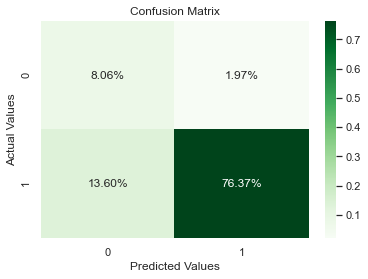

*************************




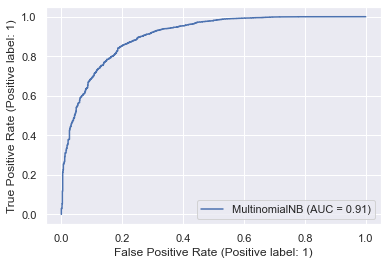

In [73]:
# Evaluvating the model using the evaluate_model function
NB_metrics = NB_model.evaluate_model(y_pred)

The performance is almost the same here, specifically even a little lesser when compared to logreg. So let's try different model.

### Model 3: Random Forest

In [74]:
# Initializing naive bayes model using the class ml_model_creator
rf = RandomForestClassifier(oob_score=True, random_state=42)

In [75]:
# Creating the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
    'n_estimators': [10, 25, 50, 100]
}

In [76]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [77]:
%time
grid_search.fit(X_train, y_train)

Wall time: 0 ns
Fitting 4 folds for each of 200 candidates, totalling 800 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [78]:
# Getting the best rf model
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, oob_score=True,
                       random_state=42)

In [79]:
# Initializing the rf_best model in the class ml_model_creator
rf_best_model = ml_model_creator(rf_best, X_train, X_test, y_train, y_test)

Wall time: 0 ns


*************************
Accuracy : 88.5%
Precision : 95.9%
Recall : 91.2%
F1 Score : 93.5%
Roc-Auc Score :88.6%
*************************


              precision    recall  f1-score   support

           0       0.45      0.65      0.53       901
           1       0.96      0.91      0.93      8080

    accuracy                           0.89      8981
   macro avg       0.70      0.78      0.73      8981
weighted avg       0.91      0.89      0.89      8981

*************************




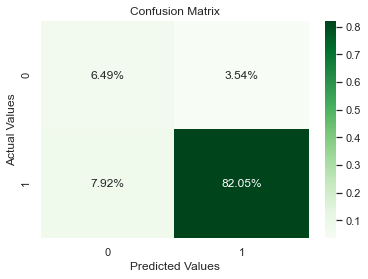

*************************




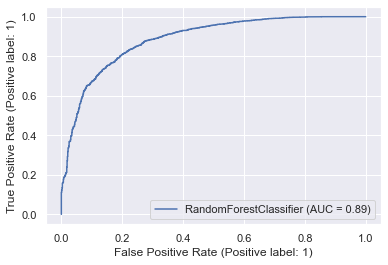

In [80]:
# Training and Predicting the Test Labels
%time
y_pred = rf_best_model.training_model()
rf_metrics = rf_best_model.evaluate_model(y_pred)

The performance is almost same as logreg model only. Not so better than that. So let's try different model, this time XG Boost

### Model 4: XGBoost

In [81]:
# Initializing XGBoost model using the class ml_model_creator
xgb_cf = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

In [82]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

In [83]:
# Instantiate the random search model
random_search = RandomizedSearchCV(estimator=xgb_cf, 
                           param_distributions=params,n_iter=150,
                           cv=5, n_jobs=-1, verbose=3, scoring = "accuracy",random_state=42)

In [224]:
%time
random_search.fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, r

In [225]:
print(random_search.best_params_)

{'subsample': 0.6, 'n_estimators': 750, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [226]:
# Getting the best XGBoost model
XGBoost_best = random_search.best_estimator_
XGBoost_best

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=750,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [227]:
# Initializing the XGBoost_best model in the class ml_model_creator
XGBoost_best_model = ml_model_creator(XGBoost_best, X_train, X_test, y_train, y_test)

Wall time: 0 ns


*************************
Accuracy : 93.1%
Precision : 95.9%
Recall : 96.4%
F1 Score : 96.2%
Roc-Auc Score :90.9%
*************************


              precision    recall  f1-score   support

           0       0.66      0.63      0.65       901
           1       0.96      0.96      0.96      8080

    accuracy                           0.93      8981
   macro avg       0.81      0.80      0.80      8981
weighted avg       0.93      0.93      0.93      8981

*************************




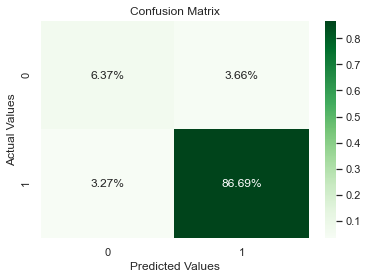

*************************




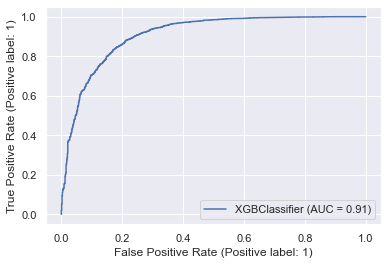

In [228]:
# Training and Predicting the Test Labels
%time
y_pred = XGBoost_best_model.training_model()
XGBoost_metrics = XGBoost_best_model.evaluate_model(y_pred)

Out of tested models, XGBoost kind of out performed. Let's reconform it once again.

#### Model Inference

In [229]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'], 
        'Logistic Regression': logreg_metrics,
        'Naive Bayes': NB_metrics,
         'Random Forrest': rf_metrics,
        'XG Boost': XGBoost_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Random Forrest',
                                                    'XG Boost'] )

df_metrics

Metric  Logistic Regression  Naive Bayes  Random Forrest  XG Boost
0   Accuracy             0.883755     0.843225        0.880414  0.930631
1  Precision             0.960833     0.974538        0.959229  0.959458
2     Recall             0.907797     0.847896        0.905569  0.963614
3    F1Score             0.933562     0.906817        0.931627  0.961531
4  Auc Score             0.870426     0.904958        0.885400  0.908647

As we thought, XG Boost looks to be a better model, let's save the XG Boost model as a pickle file for later use

#### Saving the model

In [81]:
def saving_object(obj, file_name):
    file_name = "pickle\\"+file_name+'.pkl'
    pickle.dump(obj, open(file_name, 'wb'))

In [232]:
saving_object(XGBoost_best, 'Sentiment-Based-Classification-XGBoost-Model')

In [82]:
saving_object(tfidf, 'tfidf-vectorizer')

In [83]:
saving_object(main_df, 'cleaned-final-data')

#### Step 6: Recommendation System

In [84]:
# let's take our main_df
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      29936 non-null  object
 1   name                    29936 non-null  object
 2   reviews_username        29936 non-null  object
 3   reviews_text            29936 non-null  object
 4   reviews_title           29936 non-null  object
 5   full_review_text        29936 non-null  object
 6   reviews_rating          29936 non-null  int64 
 7   user_sentiment          29936 non-null  int64 
 8   Cleaned_review_text     29936 non-null  object
 9   lemmatized_review_text  29936 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.5+ MB


There are different Approaches to develop Recommendation System, one of them is Collaborative filtering Recommendation System which is used massively and we are going to use it for our recommendation system.<br> The Collaborative filtering has two types,<br>
- User-User based recommendation
- Item-Item based recommendation

Before that, let's get our data prepared.

In [85]:
# For both the recommendation system methods, we need ratings, username and item names. Let's get all those.
recommendation_df = main_df[['id', 'name', 'reviews_rating', 'reviews_username']]
recommendation_df

id  \
0      AV13O1A8GV-KLJ3akUyj   
1      AV14LG0R-jtxr-f38QfS   
2      AV14LG0R-jtxr-f38QfS   
3      AV16khLE-jtxr-f38VFn   
4      AV16khLE-jtxr-f38VFn   
...                     ...   
29995  AVpfW8y_LJeJML437ySW   
29996  AVpfW8y_LJeJML437ySW   
29997  AVpfW8y_LJeJML437ySW   
29998  AVpfW8y_LJeJML437ySW   
29999  AVpfW8y_LJeJML437ySW   

                                                                                 name  \
0                                           Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1                                          Lundberg Organic Cinnamon Toast Rice Cakes   
2                                          Lundberg Organic Cinnamon Toast Rice Cakes   
3                                                    K-Y Love Sensuality Pleasure Gel   
4                                                    K-Y Love Sensuality Pleasure Gel   
...                                                                               ...   
29995  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29996  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29997  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29998  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   
29999  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   

       reviews_rating reviews_username  
0                   5           joshua  
1                   5        dorothy w  
2                   5        dorothy w  
3                   1          rebecca  
4                   1        walker557  
...               ...              ...  
29995               5       laurasnchz  
29996               5    scarlepadilla  
29997               5       liviasuexo  
29998               5         ktreed95  
29999               5        kcoopxoxo  

[29936 rows x 4 columns]

In [86]:
# Let's see if we have any null values
recommendation_df.isnull().sum()

id                  0
name                0
reviews_rating      0
reviews_username    0
dtype: int64

We don't have any null values. So let's split the data into train and test.<br>


In [87]:
# Test and Train split of the dataset.
train, test = train_test_split(recommendation_df, test_size=0.30, random_state=31)

In [88]:
print(train.shape)
print(test.shape)

(20955, 4)
(8981, 4)


#### User-User based recommendation

In [89]:
# Pivot the train ratings' dataset into matrix format in which columns are product names(id) and the rows are user names.
df_pivot = pd.pivot_table(train,
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(5)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            0.0                   0.0  ...   
01impala                           0.0                   0.0  ...   
02dakota                           0.0                   0.0  ...   
06stidriver                        0.0                   0.0  ...   
08dallas                           0.0                   0.0  ...   

id                AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AVpfrgjFLJeJML43BvCc  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0               

#### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [90]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [91]:
# The movies not rated by user is marked as 1 and being rated as 0 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [92]:
# Convert the dummy train dataset into matrix format.
dummy_train = pd.pivot_table(dummy_train,
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [93]:
dummy_train.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            1.0                   1.0  ...   
01impala                           1.0                   1.0  ...   
02dakota                           1.0                   1.0  ...   
06stidriver                        1.0                   1.0  ...   
08dallas                           1.0                   1.0  ...   

id                AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AVpfrgjFLJeJML43BvCc  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0                   1.0   
08dallas                           1.0                   1.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
06stidriver                        1.0               

#### Using Cosine Similarity¶

In [94]:
df_pivot.shape

(18224, 252)

In [95]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
(18224, 18224)


In [96]:
user_correlation.shape

(18224, 18224)

#### Prediction User-User

In [97]:
# We dont need any negative correlation so removing them
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [98]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 2.60896966,
        0.        ],
       [0.        , 0.        , 5.55592145, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.55592145, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.40689423, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.40689423, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.40689423, ..., 0.        , 0.        ,
        2.88675135]])

In [99]:
user_predicted_ratings.shape

(18224, 252)

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero. 

In [100]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                       0.000000             12.551319   
01impala                      5.555921             26.905605   
02dakota                      5.555921             26.905605   
06stidriver                   0.406894             17.912342   
08dallas                      0.000000              0.445435   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0              2.210643   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              6.010227   
08dallas                           0.0              0.000000   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                       0.000000              0.000000  ...   
01impala                      0.000000              1.766904  ...   
02dakota                      0.000000              1.766904  ...   
06stidriver                   3.535534              0.000000  ...   
08dallas                      0.000000              0.000000  ...   

id                AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
reviews_username                                               
00sab00                            0.0              2.738613   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              0.000000   
08dallas                           0.0              0.000000   

id                AVpfrgjFLJeJML43BvCc  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00sab00                       0.000000                   0.0   
01impala                      1.555428                   0.0   
02dakota                      1.555428                   0.0   
06stidriver                   0.000000                   0.0   
08dallas                      0.000000                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00sab00                            0.0              2.371708   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              0.000000   
08dallas                           0.0              0.000000   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00sab00                       2.870614                   0.0   
01impala                      3.764642                   0.0   
02dakota                      3.764642                   0.0   
06stidriver                   0.000000               

#### Finding the top 20 recommendation for the user

In [101]:
# Taking a random user
user_input = "00sab00" 
print(user_input)

00sab00


In [102]:
# Let's recommand top 20 recommandations for this user
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

id
AVpfPaoqLJeJML435Xk9    89.727540
AVpfRTh1ilAPnD_xYic2    61.205843
AVpf3VOfilAPnD_xjpun    43.015910
AVpf0eb2LJeJML43EVSt    42.288536
AVpf2tw1ilAPnD_xjflC    22.496613
AVpfJP1C1cnluZ0-e3Xy    22.168809
AVpfM_ytilAPnD_xXIJb    21.534794
AVpfR5m0LJeJML436K3W    13.806667
AV1YGDqsGV-KLJ3adc-O    12.551319
AVpf63aJLJeJML43F__Q    10.826994
AVpe8gsILJeJML43y6Ed    10.705407
AVpfPnrU1cnluZ0-g9rL     9.428911
AVpf5olc1cnluZ0-tPrO     9.281273
AVpfBrUZilAPnD_xTUly     8.066174
AVpfOIrkilAPnD_xXgDG     7.455491
AVpf5Z1zLJeJML43FpB-     7.442757
AVpe31o71cnluZ0-YrSD     7.323991
AVpfN6Z71cnluZ0-gZmO     6.994565
AVpfJcHuLJeJML433ZrY     6.266727
AVpe6n2_LJeJML43yOgE     5.755818
Name: 00sab00, dtype: float64

In [103]:
# let's map to the train table and get the product names

# Firstly let's make this as a dataframe
Top20_recommendations = pd.DataFrame({'id': recommendations.index}).reset_index(drop=True)

#Let's merge it with the train dataframe and get the product names
Top20_recommendations.merge(train,on='id')[['id', 'name']].drop_duplicates()

id  \
0      AVpfPaoqLJeJML435Xk9   
2355   AVpfRTh1ilAPnD_xYic2   
3142   AVpf3VOfilAPnD_xjpun   
9093   AVpf0eb2LJeJML43EVSt   
9681   AVpf2tw1ilAPnD_xjflC   
10154  AVpfJP1C1cnluZ0-e3Xy   
11583  AVpfM_ytilAPnD_xXIJb   
11766  AVpfR5m0LJeJML436K3W   
11901  AV1YGDqsGV-KLJ3adc-O   
12141  AVpf63aJLJeJML43F__Q   
12768  AVpe8gsILJeJML43y6Ed   
12989  AVpfPnrU1cnluZ0-g9rL   
13130  AVpf5olc1cnluZ0-tPrO   
13260  AVpfBrUZilAPnD_xTUly   
13360  AVpfOIrkilAPnD_xXgDG   
13451  AVpf5Z1zLJeJML43FpB-   
13553  AVpe31o71cnluZ0-YrSD   
13725  AVpfN6Z71cnluZ0-gZmO   
13773  AVpfJcHuLJeJML433ZrY   
13782  AVpe6n2_LJeJML43yOgE   

                                                                                  name  
0                      Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd  
2355               Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)  
3142                         Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total  
9093                                    The Resident Evil Collection 5 Discs (blu-Ray)  
9681                                                  Red (special Edition) (dvdvideo)  
10154                                             Clorox Disinfecting Bathroom Cleaner  
11583                                                Tostitos Bite Size Tortilla Chips  
11766                                                   Jason Aldean - They Don't Know  
11901                            Windex Original Glass Cleaner Refill 67.6oz (2 Liter)  
12141                                                  Burt's Bees Lip Shimmer, Raisin  
12768  Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack  
12989                     Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)  
13130                                        Chester's Cheese Flavored Puffcorn Snacks  
13260                             Coty Airspun Face Powder, Translucent Extra Coverage  
13360                                                            Alex Cross (dvdvideo)  
13451                            Lysol Concentrate Deodorizing Cleaner, Original Scent  
13553                    Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)  
13725                                Caress Moisturizing Body Bar Natural Silk, 4.75oz  
13773                                                                 Equals (blu-Ray)  
13782                                   Tresemme Kertatin Smooth Infusing Conditioning

We have got the top 20 best recommendations for the user using user-user based method.

#### Evaluation - User User

In [104]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2022, 4)

In [105]:
common.head()

id  \
10481  AVpf3VOfilAPnD_xjpun   
19701  AVpfJP1C1cnluZ0-e3Xy   
20083  AVpfJP1C1cnluZ0-e3Xy   
19708  AVpfJP1C1cnluZ0-e3Xy   
29188  AVpfW8y_LJeJML437ySW   

                                                                                 name  \
10481                       Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
19701                                            Clorox Disinfecting Bathroom Cleaner   
20083                                            Clorox Disinfecting Bathroom Cleaner   
19708                                            Clorox Disinfecting Bathroom Cleaner   
29188  L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz   

       reviews_rating reviews_username  
10481               5          debster  
19701               5          laura30  
20083               5          suzweet  
19708               5          krotz03  
29188               4          toshcal

In [106]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_user_based_matrix

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   5.0   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1ZSp2uglJLPUi8IQFy  AV1h6Gu0glJLPUi8IjA_  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1234asdf                           NaN                   NaN  ...   
37f5p                              NaN                   NaN  ...   
4cloroxl                           NaN                   NaN  ...   
aac06002                           NaN                   NaN  ...   
...                                ...                   ...  ...   
zapman                             NaN                   NaN  ...   
zburt5                             NaN         

In [107]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df

0      1      2      3      4      5         6      7      8      \
0        1.0    0.0    0.0    0.0    0.0    0.0  0.948683    0.0    0.0   
1        0.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0    0.0   
2        0.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0    0.0   
3        0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0    0.0   
4        0.0    0.0    0.0    0.0    1.0    0.0  0.000000    0.0    0.0   
...      ...    ...    ...    ...    ...    ...       ...    ...    ...   
18219    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   
18220    0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0    0.0   
18221    0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0    0.0   
18222    0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0    0.0   
18223    0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0    0.0   

       9      ...  18214  18215     18216  18217  18218  18219  18220  18221  \
0        0.0  ...    0.0    0.0  0.316228    0.0    0.0    0.0    0.0    0.0   
1        0.0  ...    0.0    0.0  0.000000    1.0    0.0    0.0    0.0    0.0   
2        0.0  ...    0.0    0.0  0.000000    1.0    0.0    0.0    0.0    0.0   
3        0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    1.0    1.0   
4        0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0   
...      ...  ...    ...    ...       ...    ...    ...    ...    ...    ...   
18219    0.0  ...    0.0    0.0  0.000000    0.0    0.0    1.0    0.0    0.0   
18220    0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    1.0    1.0   
18221    0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    1.0    1.0   
18222    0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    1.0    1.0   
18223    0.0  ...    0.0    0.0  0.000000    0.0    0.0    0.0    1.0    1.0   

       18222  18223  
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        1.0    1.0  
4        0.0    0.0  
...      ...    ...  
18219    0.0    0.0  
18220    1.0    1.0  
18221    1.0    1.0  
18222    1.0    1.0  
18223    1.0    1.0  

[18224 rows x 18224 columns]

In [108]:
# Let's change the index into review_usernames
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

0      1      2      3      4      5         6      7      \
reviews_username                                                              
00sab00             1.0    0.0    0.0    0.0    0.0    0.0  0.948683    0.0   
01impala            0.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0   
02dakota            0.0    1.0    1.0    0.0    0.0    0.0  0.000000    0.0   
06stidriver         0.0    0.0    0.0    1.0    0.0    0.0  0.000000    0.0   
08dallas            0.0    0.0    0.0    0.0    1.0    0.0  0.000000    0.0   

                  8      9      ...  18214  18215     18216  18217  18218  \
reviews_username                ...                                         
00sab00             0.0    0.0  ...    0.0    0.0  0.316228    0.0    0.0   
01impala            0.0    0.0  ...    0.0    0.0  0.000000    1.0    0.0   
02dakota            0.0    0.0  ...    0.0    0.0  0.000000    1.0    0.0   
06stidriver         0.0    0.0  ...    0.0    0.0  0.000000    0.0    0.0   
08dallas            0.0    0.0  ...    0.0    0.0  0.000000    0.0    0.0   

                  18219  18220  18221  18222  18223  
reviews_username                                     
00sab00             0.0    0.0    0.0    0.0    0.0  
01impala            0.0    0.0    0.0    0.0    0.0  
02dakota            0.0    0.0    0.0    0.0    0.0  
06stidriver         0.0    1.0    1.0    1.0    1.0  
08dallas            0.0    0.0    0.0    0.0    0.0  

[5 rows x 18224 columns]

In [109]:
# Let's get the common users
list_name = common.reviews_username.tolist()

#Let's change the column names into review_usernames
user_correlation_df.columns = df_pivot.index.tolist()

#Let's keep only the common users in column
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

user_correlation_df_1

00sab00  01impala  02dakota  06stidriver  08dallas  \
reviews_username                                                        
1234              0.209427  0.529813  0.529813          0.0       0.0   
1234asdf          0.000000  0.000000  0.000000          0.0       0.0   
37f5p             0.000000  0.000000  0.000000          0.0       0.0   
4cloroxl          0.000000  0.000000  0.000000          1.0       0.0   
aac06002          0.000000  0.000000  0.000000          0.0       0.0   
...                    ...       ...       ...          ...       ...   
zapman            0.000000  0.000000  0.000000          0.0       0.0   
zburt5            0.000000  0.000000  0.000000          0.0       0.0   
zebras            0.000000  0.000000  0.000000          1.0       0.0   
zippy             0.000000  0.000000  0.000000          0.0       0.0   
zitro             0.316228  0.000000  0.000000          0.0       0.0   

                  09mommy11  1085  10ten  11111111aaaaaaaaaaaaaaaaa  1143mom  \
reviews_username                                                               
1234                    0.0   0.0    0.0                        0.0      0.0   
1234asdf                0.0   0.0    0.0                        0.0      0.0   
37f5p                   0.0   0.0    0.0                        0.0      0.0   
4cloroxl                0.0   0.0    0.0                        0.0      0.0   
aac06002                0.0   0.0    0.0                        0.0      0.0   
...                     ...   ...    ...                        ...      ...   
zapman                  0.0   0.0    0.0                        0.0      1.0   
zburt5                  0.0   0.0    0.0                        0.0      0.0   
zebras                  0.0   0.0    0.0                        0.0      0.0   
zippy                   0.0   0.0    0.0                        0.0      0.0   
zitro                   0.0   0.0    0.0                        0.0      0.0   

                  ...  zowie  zozo0o    zpalma     zt313  zubb  zuttle  \
reviews_username  ...                                                    
1234              ...    0.0     0.0  0.662266  0.529813   0.0     0.0   
1234asdf          ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
37f5p             ...    0.0     0.0  0.000000  0.000000   1.0     0.0   
4cloroxl          ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
aac06002          ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
...               ...    ...     ...       ...       ...   ...     ...   
zapman            ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
zburt5            ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
zebras            ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
zippy             ...    0.0     0.0  0.000000  0.000000   0.0     0.0   
zitro             ...    0.0     0.0  1.000000  0.000000   0.0     0.0   

                  zwithanx  zxcsdfd  zyiah4  zzz1127  
reviews_username                                      
1234                   0.0      0.0     0.0      0.0  
1234asdf               0.0      0.0     0.0      0.0  
37f5p                  0.0      0.0     0.0      0.0  
4cloroxl               1.0      1.0     1.0      1.0  
aac06002               0.0      0.0     0.0      0.0  
...                    ...      ...     ...      ...  
zapman                 0.0      0.0     0.0      0.0  
zburt5                 0.0      0.0     0.0      0.0  
zebras                 1.0      1.0     1.0      1.0  
zippy                  0.0      0.0     0.0      0.0  
zitro                  0.0      0.0     0.0      0.0  

[1708 rows x 18224 columns]

In [110]:
#Let's do the same for rows, keeping only common users in rows
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_2

reviews_username      1234  1234asdf  37f5p  4cloroxl  aac06002     aaron  \
1234              1.000000       0.0    0.0       0.0       0.0  0.671627   
1234asdf          0.000000       1.0    0.0       0.0       0.0  0.000000   
37f5p             0.000000       0.0    1.0       0.0       0.0  0.000000   
4cloroxl          0.000000       0.0    0.0       1.0       0.0  0.000000   
aac06002          0.000000       0.0    0.0       0.0       1.0  0.000000   
...                    ...       ...    ...       ...       ...       ...   
zapman            0.000000       0.0    0.0       0.0       0.0  0.000000   
zburt5            0.000000       0.0    0.0       0.0       0.0  0.000000   
zebras            0.000000       0.0    0.0       1.0       0.0  0.000000   
zippy             0.000000       0.0    0.0       0.0       0.0  0.000000   
zitro             0.662266       0.0    0.0       0.0       0.0  0.536895   

reviews_username  abbi  abcgator  abigail  abismomy  ...  yeya  ygtz  \
1234               0.0       0.0      0.0  0.000000  ...   0.0   0.0   
1234asdf           0.0       0.0      0.0  0.000000  ...   0.0   0.0   
37f5p              0.0       0.0      0.0  0.000000  ...   0.0   0.0   
4cloroxl           0.0       0.0      0.0  0.707107  ...   1.0   1.0   
aac06002           0.0       0.0      0.0  0.000000  ...   0.0   0.0   
...                ...       ...      ...       ...  ...   ...   ...   
zapman             0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zburt5             0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zebras             0.0       0.0      0.0  0.707107  ...   1.0   1.0   
zippy              0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zitro              0.0       0.0      0.0  0.000000  ...   0.0   0.0   

reviews_username  yoadrian  yohnie1  yshan  zapman  zburt5  zebras  zippy  \
1234              0.529813      0.0    0.0     0.0     0.0     0.0    0.0   
1234asdf          0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
37f5p             0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
4cloroxl          0.000000      0.0    0.0     0.0     0.0     1.0    0.0   
aac06002          0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
...                    ...      ...    ...     ...     ...     ...    ...   
zapman            0.000000      0.0    0.0     1.0     0.0     0.0    0.0   
zburt5            0.000000      0.0    1.0     0.0     1.0     0.0    0.0   
zebras            0.000000      0.0    0.0     0.0     0.0     1.0    0.0   
zippy             0.000000      0.0    0.0     0.0     0.0     0.0    1.0   
zitro             0.000000      0.0    0.0     0.0     0.0     0.0    0.0   

reviews_username     zitro  
1234              0.662266  
1234asdf          0.000000  
37f5p             0.000000  
4cloroxl          0.000000  
aac06002          0.000000  
...                    ...  
zapman            0.000000  
zburt5            0.000000  
zebras            0.000000  
zippy             0.000000  
zitro             1.000000  

[1708 rows x 1708 columns]

In [111]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3

1234  1234asdf  37f5p  4cloroxl  aac06002     aaron  \
reviews_username                                                            
1234              1.000000       0.0    0.0       0.0       0.0  0.671627   
1234asdf          0.000000       1.0    0.0       0.0       0.0  0.000000   
37f5p             0.000000       0.0    1.0       0.0       0.0  0.000000   
4cloroxl          0.000000       0.0    0.0       1.0       0.0  0.000000   
aac06002          0.000000       0.0    0.0       0.0       1.0  0.000000   
...                    ...       ...    ...       ...       ...       ...   
zapman            0.000000       0.0    0.0       0.0       0.0  0.000000   
zburt5            0.000000       0.0    0.0       0.0       0.0  0.000000   
zebras            0.000000       0.0    0.0       1.0       0.0  0.000000   
zippy             0.000000       0.0    0.0       0.0       0.0  0.000000   
zitro             0.662266       0.0    0.0       0.0       0.0  0.536895   

                  abbi  abcgator  abigail  abismomy  ...  yeya  ygtz  \
reviews_username                                     ...               
1234               0.0       0.0      0.0  0.000000  ...   0.0   0.0   
1234asdf           0.0       0.0      0.0  0.000000  ...   0.0   0.0   
37f5p              0.0       0.0      0.0  0.000000  ...   0.0   0.0   
4cloroxl           0.0       0.0      0.0  0.707107  ...   1.0   1.0   
aac06002           0.0       0.0      0.0  0.000000  ...   0.0   0.0   
...                ...       ...      ...       ...  ...   ...   ...   
zapman             0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zburt5             0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zebras             0.0       0.0      0.0  0.707107  ...   1.0   1.0   
zippy              0.0       0.0      0.0  0.000000  ...   0.0   0.0   
zitro              0.0       0.0      0.0  0.000000  ...   0.0   0.0   

                  yoadrian  yohnie1  yshan  zapman  zburt5  zebras  zippy  \
reviews_username                                                            
1234              0.529813      0.0    0.0     0.0     0.0     0.0    0.0   
1234asdf          0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
37f5p             0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
4cloroxl          0.000000      0.0    0.0     0.0     0.0     1.0    0.0   
aac06002          0.000000      0.0    0.0     0.0     0.0     0.0    0.0   
...                    ...      ...    ...     ...     ...     ...    ...   
zapman            0.000000      0.0    0.0     1.0     0.0     0.0    0.0   
zburt5            0.000000      0.0    1.0     0.0     1.0     0.0    0.0   
zebras            0.000000      0.0    0.0     0.0     0.0     1.0    0.0   
zippy             0.000000      0.0    0.0     0.0     0.0     0.0    1.0   
zitro             0.000000      0.0    0.0     0.0     0.0     0.0    0.0   

                     zitro  
reviews_username            
1234              0.662266  
1234asdf          0.000000  
37f5p             0.000000  
4cloroxl          0.000000  
aac06002          0.000000  
...                    ...  
zapman            0.000000  
zburt5            0.000000  
zebras            0.000000  
zippy             0.000000  
zitro             1.000000  

[1708 rows x 1708 columns]

In [112]:
# Let's remove the negative correlation
user_correlation_df_3[user_correlation_df_3<0]=0

In [113]:
# Let's predict the ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[3.64230241, 3.84370381, 0.        , ..., 2.03798328, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.46182982, 5.        ,
        0.        ],
       [0.        , 1.74077656, 1.58943883, ..., 0.        , 0.        ,
        0.        ],
       [5.        , 2.82842712, 0.        , ..., 3.07728727, 0.        ,
        0.        ]])

In [114]:
# Let's create dummy test
dummy_test = common.copy()

In [115]:
#Keeping only the values for which the user already given rating, since we need to evaluvate it
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
dummy_test

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   5.0   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1ZSp2uglJLPUi8IQFy  AV1h6Gu0glJLPUi8IjA_  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1234asdf                           NaN                   NaN  ...   
37f5p                              NaN                   NaN  ...   
4cloroxl                           NaN                   NaN  ...   
aac06002                           NaN                   NaN  ...   
...                                ...                   ...  ...   
zapman                             NaN                   NaN  ...   
zburt5                             NaN         

In [116]:
dummy_test.shape

(1708, 130)

In [117]:
common_user_based_matrix.shape

(1708, 130)

In [118]:
# Let's check if we are getting it correctly
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [119]:
common_user_predicted_ratings

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN            277.828129   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234asdf                           NaN                   NaN   
37f5p                              NaN                   NaN   
4cloroxl                           NaN                   NaN   
aac06002                           NaN                   NaN   
...                                ...                   ...   
zapman                             NaN                   NaN   
zburt5                             NaN                   NaN   
zebras                             NaN                   NaN   
zippy                              NaN                   NaN   
zitro                              NaN                   NaN   

id                AV1ZSp2uglJLPUi8IQFy  AV1h6Gu0glJLPUi8IjA_  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1234asdf                           NaN                   NaN  ...   
37f5p                              NaN                   NaN  ...   
4cloroxl                           NaN                   NaN  ...   
aac06002                           NaN                   NaN  ...   
...                                ...                   ...  ...   
zapman                             NaN                   NaN  ...   
zburt5                             NaN         

In [120]:
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [121]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [122]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [123]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.7934203440379568


It looks good. Let's see how item based recommendation works.
#### Item Based Recommendation

In [124]:
# Let's create pivot =, this time users in columns and products in rows
df_pivot = pd.pivot_table(train,
    index='id',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot.head()

reviews_username      00sab00  01impala  02dakota  06stidriver  08dallas  \
id                                                                         
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN          NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN          NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN          NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN          NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN          NaN       NaN   

reviews_username      09mommy11  1085  10ten  11111111aaaaaaaaaaaaaaaaa  \
id                                                                        
AV13O1A8GV-KLJ3akUyj        NaN   NaN    NaN                        NaN   
AV14LG0R-jtxr-f38QfS        NaN   NaN    NaN                        NaN   
AV16khLE-jtxr-f38VFn        NaN   NaN    NaN                        NaN   
AV1YGDqsGV-KLJ3adc-O        NaN   NaN    NaN                        NaN   
AV1YIch7GV-KLJ3addeG        NaN   NaN    NaN                        NaN   

reviews_username      1143mom  ...  zowie  zozo0o  zpalma  zt313  zubb  \
id                             ...                                       
AV13O1A8GV-KLJ3akUyj      NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV14LG0R-jtxr-f38QfS      NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV16khLE-jtxr-f38VFn      NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV1YGDqsGV-KLJ3adc-O      3.0  ...    NaN     NaN     NaN    NaN   NaN   
AV1YIch7GV-KLJ3addeG      NaN  ...    NaN     NaN     NaN    NaN   NaN   

reviews_username      zuttle  zwithanx  zxcsdfd  zyiah4  zzz1127  
id                                                                
AV13O1A8GV-KLJ3akUyj     NaN       NaN      NaN     NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN       NaN      NaN     NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN       NaN      NaN     NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN       NaN      NaN     NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN       NaN      NaN     NaN      NaN  

[5 rows x 18224 columns]

In [125]:
#Normalising the movie rating for each movie for using the Adujsted Cosine this time
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username      00sab00  01impala  02dakota  06stidriver  08dallas  \
id                                                                         
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN          NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN          NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN          NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN          NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN          NaN       NaN   

reviews_username      09mommy11  1085  10ten  11111111aaaaaaaaaaaaaaaaa  \
id                                                                        
AV13O1A8GV-KLJ3akUyj        NaN   NaN    NaN                        NaN   
AV14LG0R-jtxr-f38QfS        NaN   NaN    NaN                        NaN   
AV16khLE-jtxr-f38VFn        NaN   NaN    NaN                        NaN   
AV1YGDqsGV-KLJ3adc-O        NaN   NaN    NaN                        NaN   
AV1YIch7GV-KLJ3addeG        NaN   NaN    NaN                        NaN   

reviews_username       1143mom  ...  zowie  zozo0o  zpalma  zt313  zubb  \
id                              ...                                       
AV13O1A8GV-KLJ3akUyj       NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV14LG0R-jtxr-f38QfS       NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV16khLE-jtxr-f38VFn       NaN  ...    NaN     NaN     NaN    NaN   NaN   
AV1YGDqsGV-KLJ3adc-O -1.103448  ...    NaN     NaN     NaN    NaN   NaN   
AV1YIch7GV-KLJ3addeG       NaN  ...    NaN     NaN     NaN    NaN   NaN   

reviews_username      zuttle  zwithanx  zxcsdfd  zyiah4  zzz1127  
id                                                                
AV13O1A8GV-KLJ3akUyj     NaN       NaN      NaN     NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN       NaN      NaN     NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN       NaN      NaN     NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN       NaN      NaN     NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN       NaN      NaN     NaN      NaN  

[5 rows x 18224 columns]

#### cosine similarity

In [126]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [127]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction - Item Item

In [128]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.03580569,
        0.        ],
       [0.        , 0.        , 0.01271427, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02119046, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00710285],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00710285],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00568228]])

In [129]:
item_predicted_ratings.shape

(18224, 252)

In [130]:
dummy_train.shape

(18224, 252)

Filtering the rating only for the movies not rated by the user for recommendation

In [131]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                       0.000000              0.000000   
01impala                      0.012714              0.000000   
02dakota                      0.021190              0.000000   
06stidriver                   0.000000              0.001521   
08dallas                      0.000000              0.000000   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0              0.000000   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              0.001726   
08dallas                           0.0              0.000000   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                       0.000000              0.000000  ...   
01impala                      0.000000              0.004637  ...   
02dakota                      0.000000              0.007729  ...   
06stidriver                   0.001909              0.000000  ...   
08dallas                      0.000000              0.000000  ...   

id                AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
reviews_username                                               
00sab00                            0.0              0.009245   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              0.000000   
08dallas                           0.0              0.000000   

id                AVpfrgjFLJeJML43BvCc  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
06stidriver                        0.0                   0.0   
08dallas                           0.0                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00sab00                            0.0              0.025318   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
06stidriver                        0.0              0.000000   
08dallas                           0.0              0.000000   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00sab00                       0.005122                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000                   0.0   
06stidriver                   0.000000               

#### Finding the top 20 recommendation for the user

In [133]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user name01impala
01impala


In [134]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpf5olc1cnluZ0-tPrO    0.132090
AVpfBU2S1cnluZ0-cJsO    0.069841
AVpe6PCDLJeJML43yFQH    0.036031
AVpe41TqilAPnD_xQH3d    0.027750
AVpfRTh1ilAPnD_xYic2    0.026007
AVpfOmKwLJeJML435GM7    0.025668
AVpf0thK1cnluZ0-r8vR    0.021381
AVpfkQkcLJeJML43_kEC    0.020802
AVpfbraG1cnluZ0-kqnn    0.014709
AVpfD9xTLJeJML431ig2    0.012944
AV16khLE-jtxr-f38VFn    0.012714
AVpfAkX91cnluZ0-b4d8    0.011531
AV1Ys0kTvKc47QAVgx1C    0.011382
AVpfR5m0LJeJML436K3W    0.010848
AVpfpM2yilAPnD_xfmDG    0.010826
AVpe8q4T1cnluZ0-afct    0.010820
AVpfM_ytilAPnD_xXIJb    0.010766
AVpfBO2vLJeJML430mGh    0.010483
AVpe4hlXLJeJML43xbrB    0.010340
AVpe8dHWLJeJML43y4uG    0.009840
Name: 01impala, dtype: float64

In [135]:
# Mapping with the products
# Firstly let's make this as a dataframe
Top20_item_based_recommendations = pd.DataFrame({'id': d.index}).reset_index(drop=True)

#Let's merge it with the train dataframe and get the product names
Top20_item_based_recommendations.merge(train,on='id')[['id', 'name']].drop_duplicates()

id  \
0     AVpf5olc1cnluZ0-tPrO   
130   AVpfBU2S1cnluZ0-cJsO   
149   AVpe6PCDLJeJML43yFQH   
151   AVpe41TqilAPnD_xQH3d   
677   AVpfRTh1ilAPnD_xYic2   
1464  AVpfOmKwLJeJML435GM7   
1724  AVpf0thK1cnluZ0-r8vR   
1817  AVpfkQkcLJeJML43_kEC   
1820  AVpfbraG1cnluZ0-kqnn   
1824  AVpfD9xTLJeJML431ig2   
1913  AV16khLE-jtxr-f38VFn   
1934  AVpfAkX91cnluZ0-b4d8   
1946  AV1Ys0kTvKc47QAVgx1C   
1960  AVpfR5m0LJeJML436K3W   
2095  AVpfpM2yilAPnD_xfmDG   
2121  AVpe8q4T1cnluZ0-afct   
2126  AVpfM_ytilAPnD_xXIJb   
2309  AVpfBO2vLJeJML430mGh   
2316  AVpe4hlXLJeJML43xbrB   
2333  AVpe8dHWLJeJML43y4uG   

                                                                     name  
0                               Chester's Cheese Flavored Puffcorn Snacks  
130          Power Crunch Protein Energy Bar Peanut Butter Creme Original  
149                                Wagan Smartac 80watt Inverter With Usb  
151                          Mike Dave Need Wedding Dates (dvd + Digital)  
677   Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)  
1464             Clear Scalp & Hair Therapy Total Care Nourishing Shampoo  
1724                                  100:Complete First Season (blu-Ray)  
1817                                     Cococare 100% Natural Castor Oil  
1820                                                 Kind Nut Delight Bar  
1824                                   There's Something About Mary (dvd)  
1913                                     K-Y Love Sensuality Pleasure Gel  
1934             L'oreal Paris Visible Lift Smooth Absolute, Natural Buff  
1946                               Meguiar's Deep Crystal Car Wash 64-Oz.  
1960                                       Jason Aldean - They Don't Know  
2095                                         Ragu Traditional Pasta Sauce  
2121                      Newman's Own Organics Licorice Twist, Black 5oz  
2126                                    Tostitos Bite Size Tortilla Chips  
2309                                   Mill Creek Aloe Vera & Paba Lotion  
2316                             Hawaiian Punch Berry Limeade Blast Juice  
2333                                   Sabre 2 Pack Door And Window Alarm

#### Evaluation - item-item

In [136]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username'], dtype='object')

In [137]:
# Find out the common users of test and train dataset.
common =  test[test.id.isin(train.id)]
common.shape

(8955, 4)

In [138]:
common.head(5)

id  \
26716  AVpfPPkEilAPnD_xX3cP   
11689  AVpf3VOfilAPnD_xjpun   
18300  AVpfE7puilAPnD_xUcCW   
25410  AVpfPaoqLJeJML435Xk9   
10481  AVpf3VOfilAPnD_xjpun   

                                                                                     name  \
26716  Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz   
11689                           Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
18300                                            Bilbao Nightstand Gray Oak - South Shore   
25410                     Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd   
10481                           Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   

       reviews_rating reviews_username  
26716               5       byluckyiyu  
11689               5         sdurunna  
18300               5           javier  
25410               5         dbztimmy  
10481               5          debster

In [139]:
# Creating the pivot with common products
common_item_based_matrix = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')
common_item_based_matrix

reviews_username      00dog3  02deuce  0325home  1.11E+24  11677j  1234  \
id                                                                        
AV16khLE-jtxr-f38VFn     NaN      NaN       NaN       NaN     NaN   NaN   
AV1YGDqsGV-KLJ3adc-O     NaN      NaN       NaN       NaN     NaN   NaN   
AV1YlENIglJLPUi8IHsX     NaN      NaN       NaN       NaN     NaN   NaN   
AV1YmBrdGV-KLJ3adewb     NaN      NaN       NaN       NaN     NaN   NaN   
AV1YmDL9vKc47QAVgr7_     NaN      NaN       NaN       NaN     NaN   NaN   
...                      ...      ...       ...       ...     ...   ...   
AVpfrfHF1cnluZ0-pRai     NaN      NaN       NaN       NaN     NaN   NaN   
AVpfrgjFLJeJML43BvCc     NaN      NaN       NaN       NaN     NaN   NaN   
AVpfthSailAPnD_xg3ON     NaN      NaN       NaN       NaN     NaN   NaN   
AVpftikC1cnluZ0-p31V     NaN      NaN       NaN       NaN     NaN   NaN   
AVpfvieo1cnluZ0-qdnu     NaN      NaN       NaN       NaN     NaN   NaN   

reviews_username      1234561  1234asdf  123cat123  123charlie  ...  \
id                                                              ...   
AV16khLE-jtxr-f38VFn      NaN       NaN        NaN         NaN  ...   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN        NaN         NaN  ...   
AV1YlENIglJLPUi8IHsX      NaN       NaN        NaN         NaN  ...   
AV1YmBrdGV-KLJ3adewb      NaN       NaN        NaN         NaN  ...   
AV1YmDL9vKc47QAVgr7_      NaN       NaN        NaN         NaN  ...   
...                       ...       ...        ...         ...  ...   
AVpfrfHF1cnluZ0-pRai      NaN       NaN        NaN         NaN  ...   
AVpfrgjFLJeJML43BvCc      NaN       NaN        NaN         NaN  ...   
AVpfthSailAPnD_xg3ON      NaN       NaN        NaN         NaN  ...   
AVpftikC1cnluZ0-p31V      NaN       NaN        NaN         NaN  ...   
AVpfvieo1cnluZ0-qdnu      NaN       NaN        NaN         NaN  ...   

reviews_username      zombiedad80  zombiegirl22  zookeeper  zoso60  zotox  \
id                                                                          
AV16khLE-jtxr-f38VFn          NaN           NaN        NaN     NaN    NaN   
AV1YGDqsGV-KLJ3adc-O          NaN           NaN        NaN     NaN    NaN   
AV1YlENIglJLPUi8IHsX          NaN           NaN        NaN     NaN    NaN   
AV1YmBrdGV-KLJ3adewb          NaN           NaN        NaN     NaN    NaN   
AV1YmDL9vKc47QAVgr7_          NaN           NaN        NaN     NaN    NaN   
...                           ...           ...        ...     ...    ...   
AVpfrfHF1cnluZ0-pRai          NaN           NaN        NaN     NaN    NaN   
AVpfrgjFLJeJML43BvCc          NaN           NaN        NaN     NaN    NaN   
AVpfthSailAPnD_xg3ON          NaN           NaN        NaN     NaN    NaN   
AVpftikC1cnluZ0-p31V          NaN           NaN        NaN     NaN    NaN   
AVpfvieo1cnluZ0-qdnu          NaN           NaN        NaN     NaN    NaN   

reviews_username      zsarah  zsazsa  zulaa118  zxjki  zzdiane  
id                                                              
AV16khLE-jtxr-f38VFn     NaN     NaN       NaN    NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN     NaN       NaN    NaN      NaN  
AV1YlENIglJLPUi8IHsX     NaN     NaN       NaN    NaN      NaN  
AV1YmBrdGV-KLJ3adewb     NaN     NaN       NaN    NaN      NaN  
AV1YmDL9vKc47QAVgr7_     NaN     NaN       NaN    NaN      NaN  
...                      ...     ...       ...    ...      ...  
AVpfrfHF1cnluZ0-pRai     NaN     NaN       NaN    NaN      NaN  
AVpfrgjFLJeJML43BvCc     NaN     NaN       NaN    NaN      NaN  
AVpfthSailAPnD_xg3ON     NaN     NaN       NaN    NaN      NaN  
AVpftikC1cnluZ0-p31V     NaN     NaN       NaN    NaN      NaN  
AVpfvieo1cnluZ0-qdnu     NaN     NaN       NaN    NaN      NaN  

[197 rows x 8377 columns]

In [140]:
common_item_based_matrix.shape

(197, 8377)

In [141]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)

# Let's change the index into review_usernames
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

# Let's get the common users
list_name = common.id.tolist()

#Let's change the column names into item_names
item_correlation_df.columns = df_subtracted.index.tolist()

#Let's keep only the common items in column
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

#Let's do the same for rows, keeping only common items in rows
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
id                                                                 
AV16khLE-jtxr-f38VFn                   1.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   1.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   1.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   1.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   1.0                   0.0   

                      AV1Yn94nvKc47QAVgtst  AV1Ynb3bglJLPUi8IJxJ  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  ...  \
id                                                                ...   
AV16khLE-jtxr-f38VFn              0.000000                   0.0  ...   
AV1YGDqsGV-KLJ3adc-O              0.003657                   0.0  ...   
AV1YlENIglJLPUi8IHsX              0.000000                   0.0  ...   
AV1YmBrdGV-KLJ3adewb              0.000000                   0.0  ...   
AV1YmDL9vKc47QAVgr7_              0.000000                   0.0  ...   

                      AVpfpM2yilAPnD_xfmDG  AVpfqW4WilAPnD_xf7a_  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AVpfr5cb1cnluZ0-pZFp  AVpfrFDZLJeJML43Bmv0  \
id                                                                 
AV16khLE-jtxr-f38VFn              0.000000                   0.0   
AV1YGDqsGV-KLJ3adc-O              0.055972                   0.0   
AV1YlENIglJLPUi8IHsX              0.000000                   0.0   
AV1YmBrdGV-KLJ3adewb              0.000000                   0.0   
AV1YmDL9vKc47QAVgr7_              0.000000                   0.0   

                      AVpfrTyiLJeJML43BrSI  AVpfrfHF1cnluZ0-pRai  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   
AV1YlENIglJLPUi8IHsX                   0.0                   0.0   
AV1YmBrdGV-KLJ3adewb                   0.0                   0.0   
AV1YmDL9vKc47QAVgr7_                   0.0                   0.0   

                      AVpfrgjFLJeJML43BvCc  AVpfthSailAPnD_xg3ON  \
id                                                                 
AV16khLE-jtxr-f38VFn               

In [142]:
# Let's remove the negative correlation
item_correlation_df_3[item_correlation_df_3<0]=0

# Let's predict the ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.01695237, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02105944, 0.        , 0.00152125, ..., 0.        , 0.0006085 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04219742],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00691744],
       [0.        , 0.        , 0.00710285, ..., 0.        , 0.00284114,
        0.        ]])

In [143]:
common_item_predicted_ratings.shape

(197, 8377)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user.

In [144]:
# Let's create dummy test
dummy_test = common.copy()

#Keeping only the values for which the user already given rating, since we need to evaluvate it
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='id', columns='reviews_username', values='reviews_rating').fillna(0)

In [145]:
dummy_test.shape

(197, 8377)

In [146]:
common_item_based_matrix.shape

(197, 8377)

In [147]:
# Let's check if we are getting it correctly
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [148]:
common_item_predicted_ratings

reviews_username      00dog3  02deuce  0325home  1.11E+24  11677j  1234  \
id                                                                        
AV16khLE-jtxr-f38VFn     0.0      0.0       0.0       0.0     0.0   0.0   
AV1YGDqsGV-KLJ3adc-O     0.0      0.0       0.0       0.0     0.0   0.0   
AV1YlENIglJLPUi8IHsX     0.0      0.0       0.0       0.0     0.0   0.0   
AV1YmBrdGV-KLJ3adewb     0.0      0.0       0.0       0.0     0.0   0.0   
AV1YmDL9vKc47QAVgr7_     0.0      0.0       0.0       0.0     0.0   0.0   
...                      ...      ...       ...       ...     ...   ...   
AVpfrfHF1cnluZ0-pRai     0.0      0.0       0.0       0.0     0.0   0.0   
AVpfrgjFLJeJML43BvCc     0.0      0.0       0.0       0.0     0.0   0.0   
AVpfthSailAPnD_xg3ON     0.0      0.0       0.0       0.0     0.0   0.0   
AVpftikC1cnluZ0-p31V     0.0      0.0       0.0       0.0     0.0   0.0   
AVpfvieo1cnluZ0-qdnu     0.0      0.0       0.0       0.0     0.0   0.0   

reviews_username      1234561  1234asdf  123cat123  123charlie  ...  \
id                                                              ...   
AV16khLE-jtxr-f38VFn      0.0       0.0        0.0         0.0  ...   
AV1YGDqsGV-KLJ3adc-O      0.0       0.0        0.0         0.0  ...   
AV1YlENIglJLPUi8IHsX      0.0       0.0        0.0         0.0  ...   
AV1YmBrdGV-KLJ3adewb      0.0       0.0        0.0         0.0  ...   
AV1YmDL9vKc47QAVgr7_      0.0       0.0        0.0         0.0  ...   
...                       ...       ...        ...         ...  ...   
AVpfrfHF1cnluZ0-pRai      0.0       0.0        0.0         0.0  ...   
AVpfrgjFLJeJML43BvCc      0.0       0.0        0.0         0.0  ...   
AVpfthSailAPnD_xg3ON      0.0       0.0        0.0         0.0  ...   
AVpftikC1cnluZ0-p31V      0.0       0.0        0.0         0.0  ...   
AVpfvieo1cnluZ0-qdnu      0.0       0.0        0.0         0.0  ...   

reviews_username      zombiedad80  zombiegirl22  zookeeper  zoso60  zotox  \
id                                                                          
AV16khLE-jtxr-f38VFn          0.0           0.0        0.0     0.0    0.0   
AV1YGDqsGV-KLJ3adc-O          0.0           0.0        0.0     0.0    0.0   
AV1YlENIglJLPUi8IHsX          0.0           0.0        0.0     0.0    0.0   
AV1YmBrdGV-KLJ3adewb          0.0           0.0        0.0     0.0    0.0   
AV1YmDL9vKc47QAVgr7_          0.0           0.0        0.0     0.0    0.0   
...                           ...           ...        ...     ...    ...   
AVpfrfHF1cnluZ0-pRai          0.0           0.0        0.0     0.0    0.0   
AVpfrgjFLJeJML43BvCc          0.0           0.0        0.0     0.0    0.0   
AVpfthSailAPnD_xg3ON          0.0           0.0        0.0     0.0    0.0   
AVpftikC1cnluZ0-p31V          0.0           0.0        0.0     0.0    0.0   
AVpfvieo1cnluZ0-qdnu          0.0           0.0        0.0     0.0    0.0   

reviews_username      zsarah  zsazsa  zulaa118  zxjki  zzdiane  
id                                                              
AV16khLE-jtxr-f38VFn     0.0     0.0       0.0    0.0      0.0  
AV1YGDqsGV-KLJ3adc-O     0.0     0.0       0.0    0.0      0.0  
AV1YlENIglJLPUi8IHsX     0.0     0.0       0.0    0.0      0.0  
AV1YmBrdGV-KLJ3adewb     0.0     0.0       0.0    0.0      0.0  
AV1YmDL9vKc47QAVgr7_     0.0     0.0       0.0    0.0      0.0  
...                      ...     ...       ...    ...      ...  
AVpfrfHF1cnluZ0-pRai     0.0     0.0       0.0    0.0      0.0  
AVpfrgjFLJeJML43BvCc     0.0     0.0       0.0    0.0      0.0  
AVpfthSailAPnD_xg3ON     0.0     0.0       0.0    0.0      0.0  
AVpftikC1cnluZ0-p31V     0.0     0.0       0.0    0.0      0.0  
AVpfvieo1cnluZ0-qdnu     0.0     0.0       0.0    0.0      0.0  

[197 rows x 8377 columns]

In [149]:
common_ = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')

In [150]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [151]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [152]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5606755283078093


While comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model is better in this case, since it has lower RMSE value(1.79<3.56)

In [153]:
# saving the correlation matrix of user based recommender 
saving_object(user_final_rating, "final-user-rating")

#### Step 7: Final Product Recommendations - Using Recommendation system and Sentiment model

Let's get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.

In [161]:
# First lets check the sentiment ML model with one positive and one negative samples
X_sample = tfidf.transform(["I loved the product"])
y_pred_sample = XGBoost_best.predict(X_sample)
y_pred_sample

array([1])

In [162]:
X_sample = tfidf.transform(["waste of money"])
y_pred_sample = XGBoost_best.predict(X_sample)
y_pred_sample

array([0])

Let's create a function to use both the models and get the top 5 recommendations

In [163]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = main_df[main_df.id.isin(recommendations)]
        X =  tfidf.transform(temp["lemmatized_review_text"].values.astype(str))
        temp["predicted_sentiment"]= XGBoost_best.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

Let's test with one positive(existing user) and negative (user doesn't exist) sample.

In [164]:
#testing the above fuction using positive sample(existing user)
get_sentiment_recommendations("02dakota")

name  \
7                                       Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
6                                                            Clorox Disinfecting Bathroom Cleaner   
2                 Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter   
16                                                 The Resident Evil Collection 5 Discs (blu-Ray)   
15                                   Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)   
13                            Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)   
10                                                                 Jason Aldean - They Don't Know   
14                                                               Red (special Edition) (dvdvideo)   
0                                                             100:Complete First Season (blu-Ray)   
5                                                       Chester's Cheese Flavored Puffcorn Snacks   
3                                                                 Burt's Bees Lip Shimmer, Raisin   
4                                               Caress Moisturizing Body Bar Natural Silk, 4.75oz   
18                                                              Tostitos Bite Size Tortilla Chips   
17                                                             There's Something About Mary (dvd)   
12                                           My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)   
1                                                                           Alex Cross (dvdvideo)   
8                                         Cuisinart174 Electric Juicer - Stainless Steel Cje-1000   
9   Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com   
11                                                   Mike Dave Need Wedding Dates (dvd + Digital)   
19                                          Windex Original Glass Cleaner Refill 67.6oz (2 Liter)   

    predicted_sentiment  pos_review_count  total_review_count  \
7                  8525              8463                8525   
6                  2039              2011                2039   
2                   313               308                 313   
16                  845               819                 845   
15                  186               180                 186   
13                 1142              1104                1142   
10                  204               196                 204   
14                  672               643                 672   
0                   139               133                 139   
5                   177               169                 177   
3                   873               814                 873   
4                    68                63                  68   
18                  264               244                 264   
17                  130               119                 130   
12                  668               604                 668   
1                   141               127                 141   
8                   103                92                 103   
9                   349               305                 349   
11                  757               637                 757   
19                  348               268                 348   

    pos_sentiment_percent  
7                   99.27  
6                   98.63  
2                   98.40  
16                  96.92  
15                  96.77  
13                  96.67  
10                  96.08  
14                  95.68  
0                   95.68  
5                   95.48  
3                   93.24  
4                   92.65  
18                  92.42  
17                  91.54  
12                  90.42  
1                   90.07  
8                   89.32  
9                   87.39  
11                  84.15  
19                  77.01

In [165]:
#Let's get the top 5
get_sentiment_recommendations("02dakota")[:5]

name  \
7                         Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total   
6                                              Clorox Disinfecting Bathroom Cleaner   
2   Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter   
16                                   The Resident Evil Collection 5 Discs (blu-Ray)   
15                     Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)   

    predicted_sentiment  pos_review_count  total_review_count  \
7                  8525              8463                8525   
6                  2039              2011                2039   
2                   313               308                 313   
16                  845               819                 845   
15                  186               180                 186   

    pos_sentiment_percent  
7                   99.27  
6                   98.63  
2                   98.40  
16                  96.92  
15                  96.77

In [166]:
#testing the above fuction using negative (user doesn't exist) sample.
get_sentiment_recommendations("bharath")

User name bharath doesn't exist
